### Decision Tree ###

In [61]:
import pandas as pd

In [62]:
#df = pd.read_csv("../data/kickstarter_cleaned.csv")
df = pd.read_csv("../data/kickstarter_one_hot_cleaned.csv")

In [63]:
#one-hot encode

#category
df_encoded = pd.get_dummies(df, columns=['category'])

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#eliminate all non-numerical columns
df = df.select_dtypes(include=['number'])
df.drop([
    'usd_pledged', 'goal'
], axis=1)

#print(df.columns)
#print(df.head(2))

#y is the target feature
y = df['SuccessfulBool']
#X consists of all features other than the target feature
X = df.drop('SuccessfulBool', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

spotlight                      1.0
goal                           0.0
launched_at_day                0.0
world                          0.0
new                            0.0
help                           0.0
app                            0.0
DeadlineWeekend                0.0
LaunchedTuesday                0.0
TOPCOUNTRY                     0.0
launch_to_state_change_days    0.0
launch_to_deadline_days        0.0
create_to_launch_days          0.0
launched_at_hr                 0.0
launched_at_yr                 0.0
launched_at_month              0.0
disable_communication          0.0
created_at_hr                  0.0
created_at_day                 0.0
created_at_month               0.0
deadline_hr                    0.0
deadline_day                   0.0
deadline_month                 0.0
blurb_len_clean                0.0
name_len_clean                 0.0
usd_pledged                    0.0
static_usd_rate                0.0
backers_count                  0.0
staff_pick          

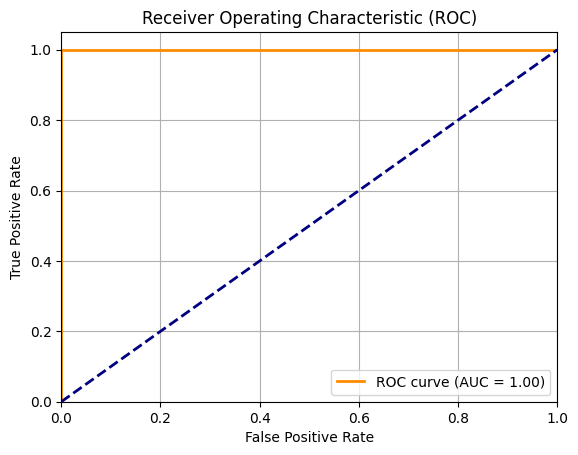

spotlight                      1.0
goal                           0.0
launched_at_day                0.0
world                          0.0
new                            0.0
help                           0.0
app                            0.0
DeadlineWeekend                0.0
LaunchedTuesday                0.0
TOPCOUNTRY                     0.0
launch_to_state_change_days    0.0
launch_to_deadline_days        0.0
create_to_launch_days          0.0
launched_at_hr                 0.0
launched_at_yr                 0.0
launched_at_month              0.0
disable_communication          0.0
created_at_hr                  0.0
created_at_day                 0.0
created_at_month               0.0
deadline_hr                    0.0
deadline_day                   0.0
deadline_month                 0.0
blurb_len_clean                0.0
name_len_clean                 0.0
usd_pledged                    0.0
static_usd_rate                0.0
backers_count                  0.0
staff_pick          

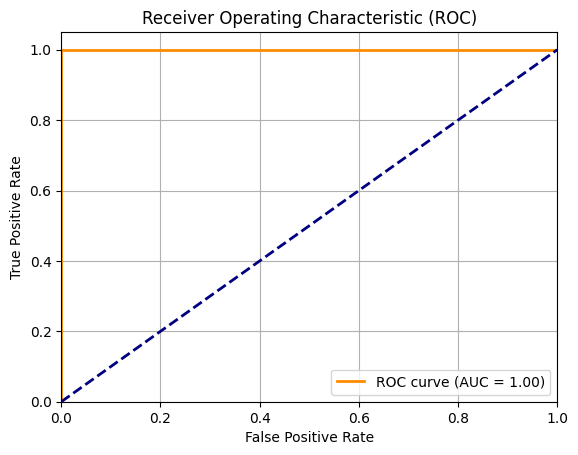

spotlight                      1.0
goal                           0.0
launched_at_day                0.0
world                          0.0
new                            0.0
help                           0.0
app                            0.0
DeadlineWeekend                0.0
LaunchedTuesday                0.0
TOPCOUNTRY                     0.0
launch_to_state_change_days    0.0
launch_to_deadline_days        0.0
create_to_launch_days          0.0
launched_at_hr                 0.0
launched_at_yr                 0.0
launched_at_month              0.0
disable_communication          0.0
created_at_hr                  0.0
created_at_day                 0.0
created_at_month               0.0
deadline_hr                    0.0
deadline_day                   0.0
deadline_month                 0.0
blurb_len_clean                0.0
name_len_clean                 0.0
usd_pledged                    0.0
static_usd_rate                0.0
backers_count                  0.0
staff_pick          

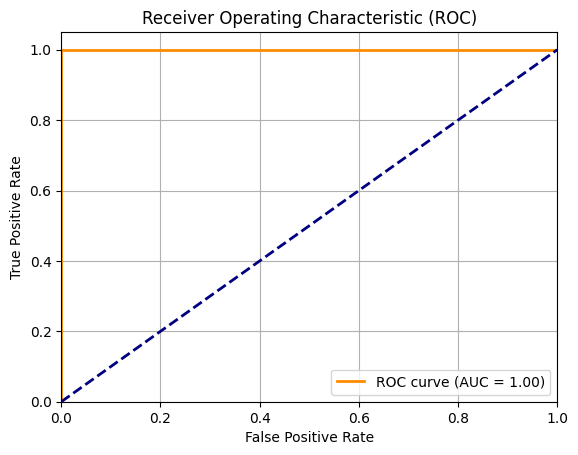

spotlight                      1.0
goal                           0.0
launched_at_day                0.0
world                          0.0
new                            0.0
help                           0.0
app                            0.0
DeadlineWeekend                0.0
LaunchedTuesday                0.0
TOPCOUNTRY                     0.0
launch_to_state_change_days    0.0
launch_to_deadline_days        0.0
create_to_launch_days          0.0
launched_at_hr                 0.0
launched_at_yr                 0.0
launched_at_month              0.0
disable_communication          0.0
created_at_hr                  0.0
created_at_day                 0.0
created_at_month               0.0
deadline_hr                    0.0
deadline_day                   0.0
deadline_month                 0.0
blurb_len_clean                0.0
name_len_clean                 0.0
usd_pledged                    0.0
static_usd_rate                0.0
backers_count                  0.0
staff_pick          

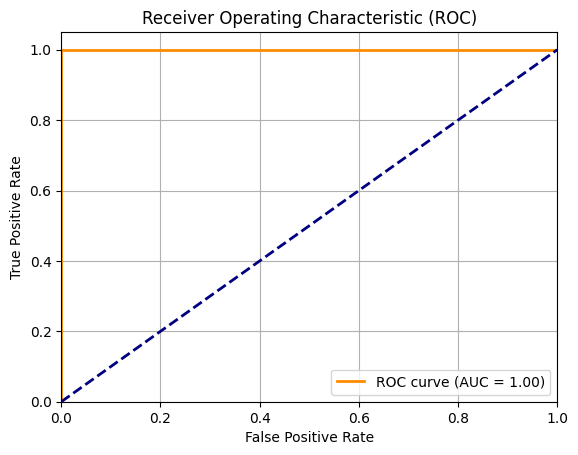

In [65]:
for i in range(1, 5):
    clf = DecisionTreeClassifier(max_depth=i, random_state=42)
    clf.fit(X_train, y_train)

    cv_scores = cross_val_score(clf, X, y, cv=10)

    #examine the feature importance
    importances = clf.feature_importances_
    feature_ranks = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    print(feature_ranks)
    #split_feature_index = clf.tree_.feature[0]
    #print("Split on feature:", X.columns[split_feature_index])

    print(f"Tree depth {i}")
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {cv_scores.mean():.4f}")
    print(f"Standard deviation of accuracy: {cv_scores.std():.4f}")

    y_scores = clf.predict_proba(X_test)[:, 1]  # Get probability for the positive class

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
        

In [66]:
#messing around with sample prediction
print(clf.predict(X.iloc[0:1]))

[0]


`Spotlight` is a problem here. It seems that the target is leaked to the training by the `spotlight`. Looking more into it, the spotlight on kickstarter features projects that were already successful. E.g. only a successful kickstarter will reach the kickstarter spotlight.

We need to omit the spotlight feature to avoid leakage of the target feature to the training data.

In [ ]:
#drop spotlight
#df.drop('spotlight', axis=1, inplace=True)
df.drop('spotlight', axis=1, inplace=True)
df.drop('usd_pledged', axis=1, inplace=True)

#y is the target feature
y = df['SuccessfulBool']
#X consists of all features other than the target feature
X = df.drop('SuccessfulBool', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

KeyError: "['spotlight'] not found in axis"

Tree depth 1
backers_count    1.0
dtype: float64
Cross-validation scores: [0.88032946 0.84544574 0.90741638 0.76442075 0.78526418 0.88996607
 0.65244789 0.6839554  0.73630635 0.78623364]
Mean accuracy: 0.7932
Standard deviation of accuracy: 0.0829


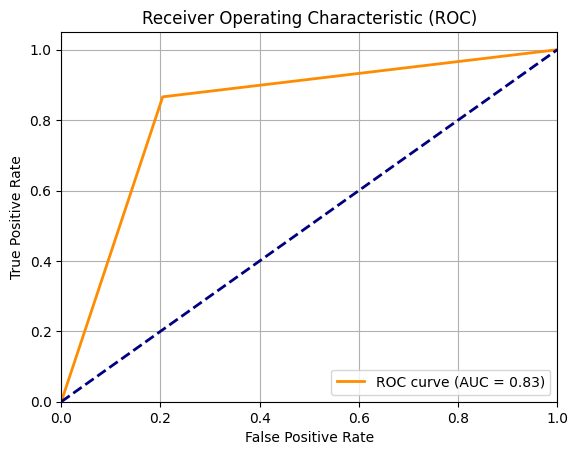

Tree depth 2
backers_count    0.779379
goal             0.220621
dtype: float64
Cross-validation scores: [0.84496124 0.875      0.89190499 0.84682501 0.77023752 0.84100824
 0.77702375 0.77944741 0.79398934 0.81047019]
Mean accuracy: 0.8231
Standard deviation of accuracy: 0.0408


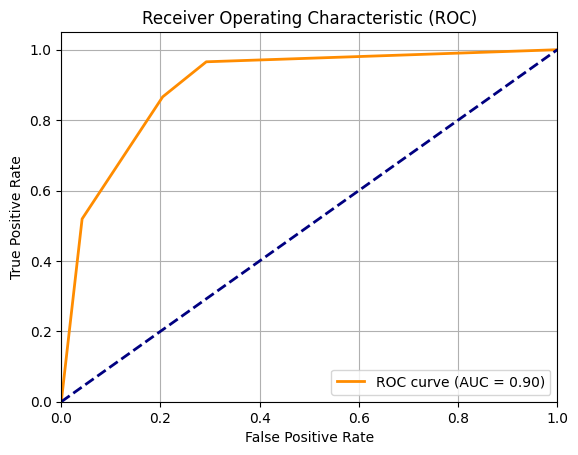

Tree depth 3
backers_count    0.540947
usd_pledged      0.305926
goal             0.153127
dtype: float64
Cross-validation scores: [0.9253876  0.92926357 0.96316045 0.8982065  0.90014542 0.9515269
 0.85264178 0.84827921 0.88221037 0.89142026]
Mean accuracy: 0.9042
Standard deviation of accuracy: 0.0364


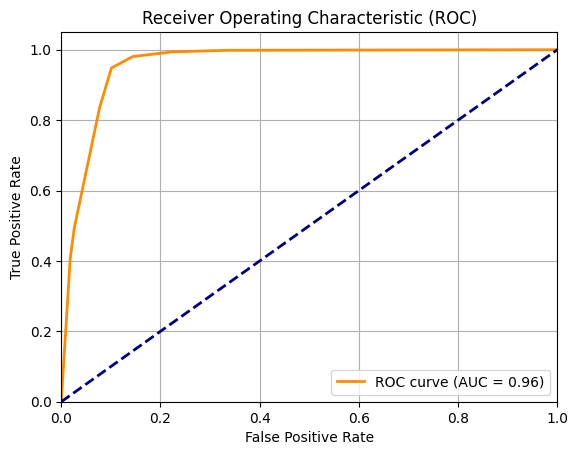

Tree depth 4
backers_count                  0.467862
usd_pledged                    0.264594
goal                           0.234573
canceled                       0.019708
launch_to_state_change_days    0.009795
static_usd_rate                0.003467
dtype: float64
Cross-validation scores: [0.95542636 0.96172481 0.96897722 0.91371789 0.94086282 0.96752302
 0.88511876 0.87154629 0.91468735 0.92777508]
Mean accuracy: 0.9307
Standard deviation of accuracy: 0.0326


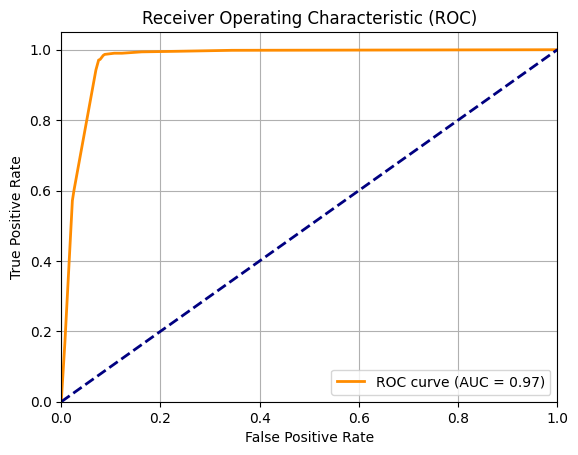

Tree depth 5
backers_count                  0.452186
usd_pledged                    0.275985
goal                           0.223139
canceled                       0.025069
launch_to_state_change_days    0.014852
static_usd_rate                0.005261
launch_to_deadline_days        0.002346
created_at_month               0.001162
dtype: float64
Cross-validation scores: [0.97044574 0.97189922 0.98545807 0.93456132 0.9592826  0.97091614
 0.88608822 0.93601551 0.93795444 0.93795444]
Mean accuracy: 0.9491
Standard deviation of accuracy: 0.0273


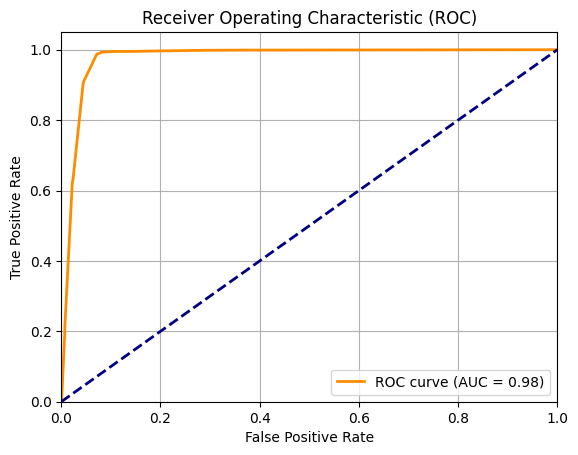

Tree depth 6
backers_count                  0.431186
usd_pledged                    0.268863
goal                           0.235445
canceled                       0.024932
launch_to_state_change_days    0.023150
static_usd_rate                0.006549
disable_communication          0.005753
launch_to_deadline_days        0.002235
created_at_month               0.001107
launched_at_yr                 0.000780
dtype: float64
Cross-validation scores: [0.9748062  0.9752907  0.98739699 0.96364518 0.96946195 0.98351915
 0.93698497 0.94861852 0.96122152 0.94813379]
Mean accuracy: 0.9649
Standard deviation of accuracy: 0.0156


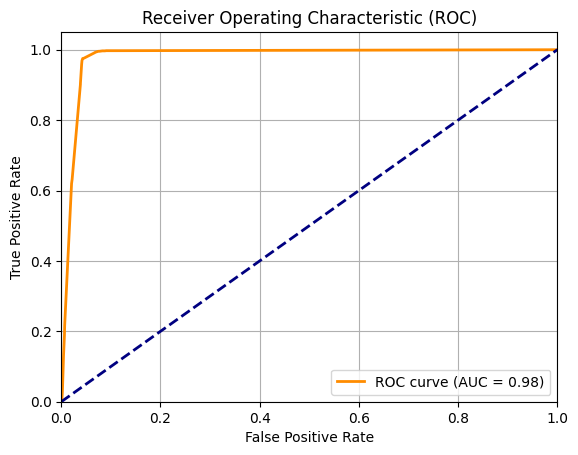

Tree depth 7
backers_count                  0.419841
usd_pledged                    0.271468
goal                           0.236123
canceled                       0.024996
launch_to_state_change_days    0.022992
static_usd_rate                0.009092
disable_communication          0.005969
launch_to_deadline_days        0.003512
launched_at_yr                 0.001462
blurb_len_clean                0.001127
created_at_month               0.001079
name_len_clean                 0.000532
created_at_hr                  0.000469
created_at_day                 0.000450
deadline_day                   0.000375
create_to_launch_days          0.000328
launched_at_day                0.000185
dtype: float64
Cross-validation scores: [0.97335271 0.97965116 0.98691226 0.96606883 0.9733398  0.98642753
 0.93989336 0.95395056 0.97382453 0.95249636]
Mean accuracy: 0.9686
Standard deviation of accuracy: 0.0147


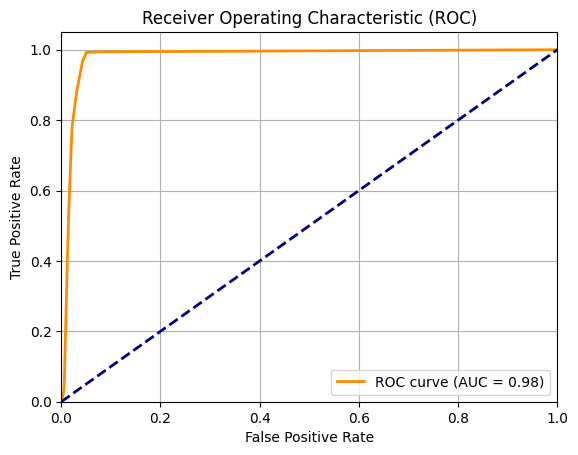

Tree depth 8
backers_count                  0.401006
usd_pledged                    0.274393
goal                           0.247922
launch_to_state_change_days    0.024628
canceled                       0.023874
static_usd_rate                0.009998
disable_communication          0.007651
launch_to_deadline_days        0.003355
blurb_len_clean                0.001253
launched_at_yr                 0.001106
created_at_month               0.001031
created_at_hr                  0.000755
name_len_clean                 0.000546
world                          0.000514
created_at_day                 0.000430
deadline_day                   0.000337
create_to_launch_days          0.000314
launched_at_hr                 0.000269
launched_at_month              0.000269
launched_at_day                0.000177
new                            0.000173
dtype: float64
Cross-validation scores: [0.98207364 0.98304264 0.98885119 0.97140087 0.97721764 0.98982065
 0.94958798 0.96703829 0.97430926 0.9621

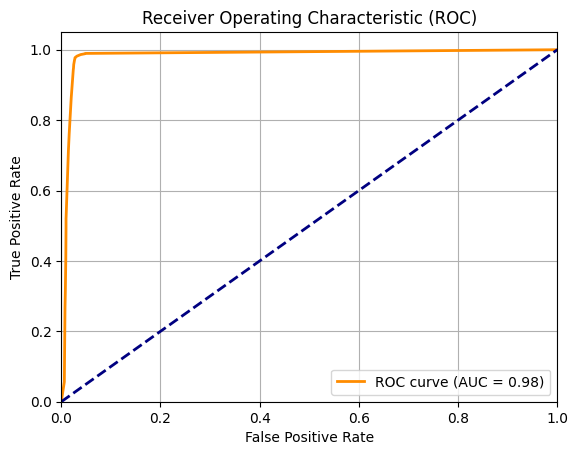

Tree depth 9
backers_count                  0.392926
usd_pledged                    0.280605
goal                           0.244261
launch_to_state_change_days    0.023447
canceled                       0.023359
static_usd_rate                0.014411
disable_communication          0.007792
launch_to_deadline_days        0.003583
blurb_len_clean                0.001530
created_at_month               0.001359
launched_at_yr                 0.001082
deadline_day                   0.000912
created_at_day                 0.000857
launched_at_day                0.000533
create_to_launch_days          0.000514
created_at_hr                  0.000505
new                            0.000476
launched_at_month              0.000367
deadline_hr                    0.000340
world                          0.000327
name_len_clean                 0.000316
DeadlineWeekend                0.000263
help                           0.000234
dtype: float64
Cross-validation scores: [0.98352713 0.98352713 0.98

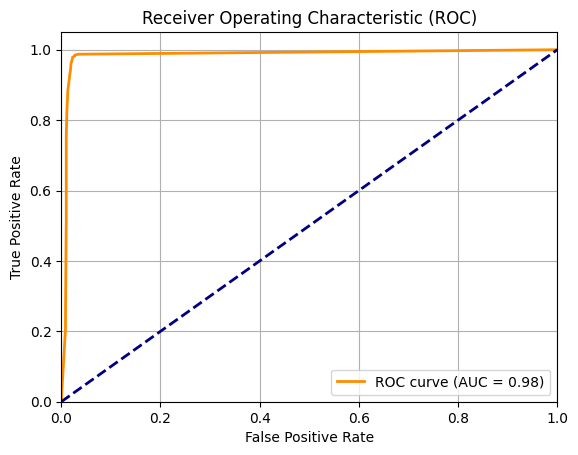

Tree depth 10
backers_count                  0.384168
usd_pledged                    0.280596
goal                           0.247528
canceled                       0.022803
launch_to_state_change_days    0.022733
static_usd_rate                0.019015
disable_communication          0.008252
launch_to_deadline_days        0.003204
launched_at_yr                 0.001737
blurb_len_clean                0.001600
created_at_month               0.001155
deadline_day                   0.001147
created_at_hr                  0.001040
name_len_clean                 0.000830
launched_at_month              0.000760
new                            0.000658
deadline_hr                    0.000606
create_to_launch_days          0.000573
created_at_day                 0.000526
launched_at_day                0.000520
world                          0.000319
help                           0.000228
dtype: float64
Cross-validation scores: [0.98449612 0.98401163 0.98836646 0.97721764 0.98109549 0.98885119

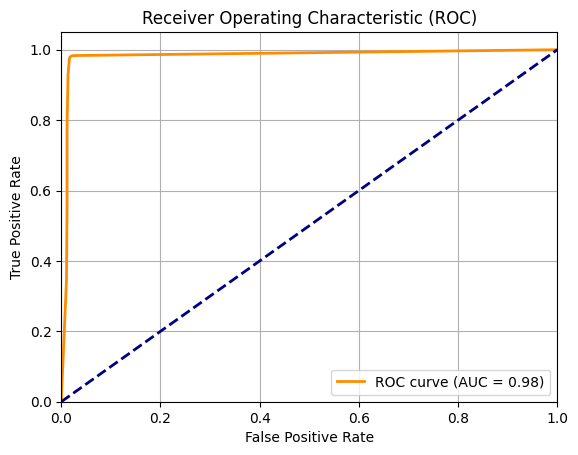

Tree depth 11
backers_count                  0.380501
usd_pledged                    0.282225
goal                           0.247408
canceled                       0.022618
launch_to_state_change_days    0.021963
static_usd_rate                0.019241
disable_communication          0.008185
launch_to_deadline_days        0.003250
blurb_len_clean                0.002170
launched_at_yr                 0.002027
launched_at_month              0.001226
created_at_month               0.001203
deadline_day                   0.001132
created_at_hr                  0.001032
new                            0.000950
deadline_hr                    0.000853
launched_at_day                0.000844
created_at_day                 0.000776
create_to_launch_days          0.000720
name_len_clean                 0.000597
staff_pick                     0.000333
TOPCOUNTRY                     0.000315
help                           0.000305
launched_at_hr                 0.000127
dtype: float64
Cross-valid

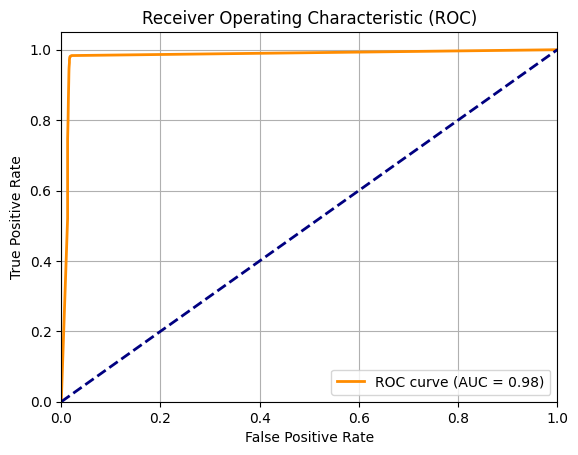

Tree depth 12
backers_count                  0.379671
usd_pledged                    0.280482
goal                           0.247231
launch_to_state_change_days    0.023960
canceled                       0.022492
static_usd_rate                0.019521
disable_communication          0.008139
launch_to_deadline_days        0.003232
blurb_len_clean                0.002205
launched_at_yr                 0.001882
launched_at_month              0.001528
created_at_hr                  0.001346
created_at_month               0.001196
deadline_day                   0.001109
name_len_clean                 0.000987
created_at_day                 0.000924
launched_at_day                0.000839
new                            0.000776
create_to_launch_days          0.000716
launched_at_hr                 0.000352
staff_pick                     0.000331
deadline_hr                    0.000328
LaunchedTuesday                0.000270
deadline_month                 0.000225
TOPCOUNTRY                

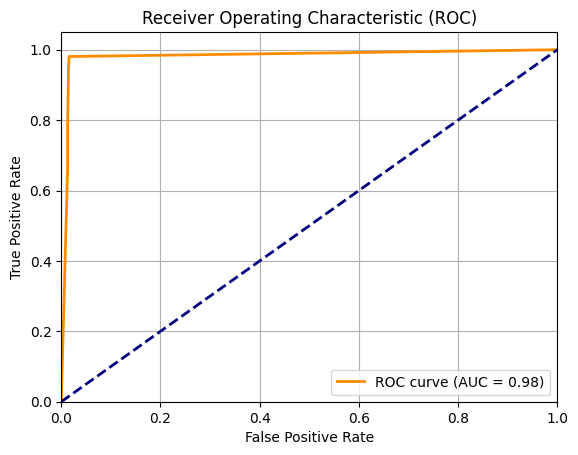

Tree depth 13
backers_count                  0.377907
usd_pledged                    0.281251
goal                           0.246742
launch_to_state_change_days    0.023594
canceled                       0.022417
static_usd_rate                0.019175
disable_communication          0.008112
launch_to_deadline_days        0.003980
blurb_len_clean                0.002113
launched_at_yr                 0.001890
created_at_day                 0.001369
created_at_hr                  0.001354
launched_at_hr                 0.001352
launched_at_month              0.001299
created_at_month               0.001269
deadline_day                   0.000931
new                            0.000773
name_len_clean                 0.000760
launched_at_day                0.000626
create_to_launch_days          0.000562
deadline_hr                    0.000551
DeadlineWeekend                0.000421
help                           0.000332
staff_pick                     0.000330
world                     

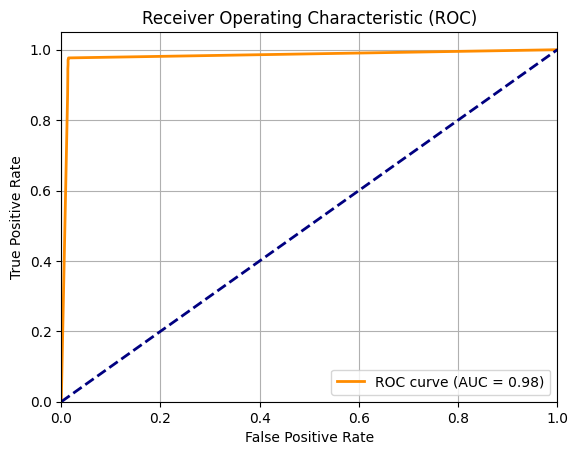

Tree depth 14
backers_count                  0.378392
usd_pledged                    0.279575
goal                           0.246308
launch_to_state_change_days    0.023816
canceled                       0.022365
static_usd_rate                0.018818
disable_communication          0.008094
launch_to_deadline_days        0.003214
launched_at_yr                 0.002160
blurb_len_clean                0.002019
deadline_day                   0.001514
deadline_hr                    0.001433
created_at_hr                  0.001334
create_to_launch_days          0.001264
created_at_month               0.001264
launched_at_hr                 0.001228
launched_at_day                0.001173
launched_at_month              0.001165
created_at_day                 0.000816
TOPCOUNTRY                     0.000787
new                            0.000771
name_len_clean                 0.000758
staff_pick                     0.000329
app                            0.000314
world                     

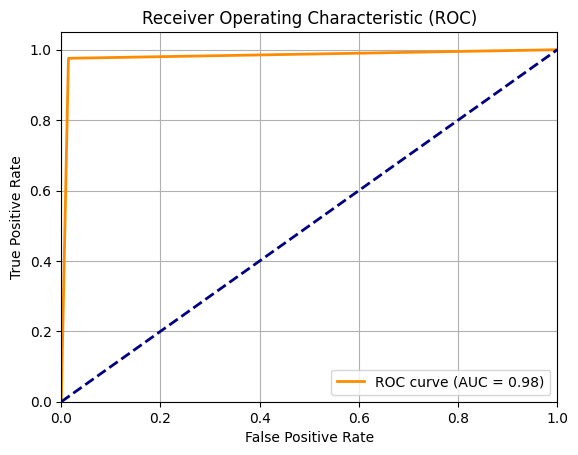

Tree depth 15
backers_count                  0.378156
usd_pledged                    0.280197
goal                           0.245903
launch_to_state_change_days    0.024289
canceled                       0.022345
static_usd_rate                0.018801
disable_communication          0.008086
launch_to_deadline_days        0.003211
launched_at_yr                 0.002158
deadline_day                   0.001764
blurb_len_clean                0.001615
launched_at_month              0.001500
created_at_month               0.001486
created_at_hr                  0.001333
deadline_hr                    0.001252
create_to_launch_days          0.001047
new                            0.000994
created_at_day                 0.000994
launched_at_day                0.000848
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
staff_pick                     0.000329
TOPCOUNTRY                

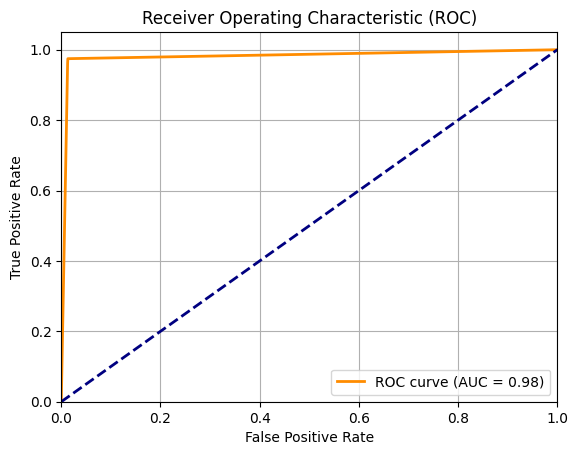

Tree depth 16
backers_count                  0.378031
usd_pledged                    0.280104
goal                           0.245929
launch_to_state_change_days    0.024281
canceled                       0.022338
static_usd_rate                0.018795
disable_communication          0.008083
launch_to_deadline_days        0.003433
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001333
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000994
launched_at_day                0.000848
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
staff_pick                     0.000329
TOPCOUNTRY                

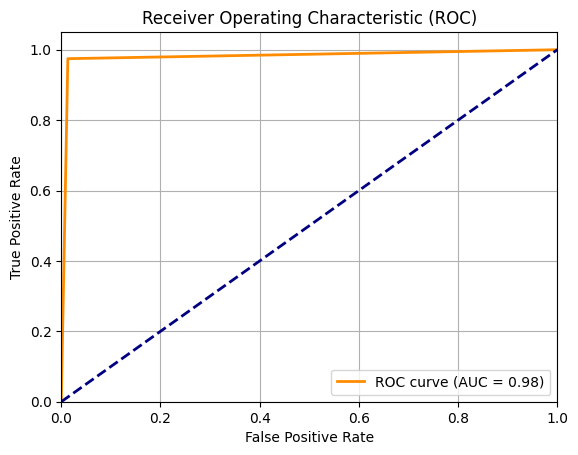

Tree depth 17
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

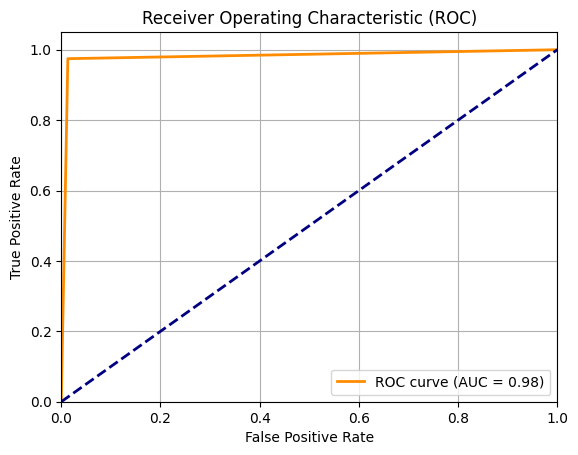

Tree depth 18
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

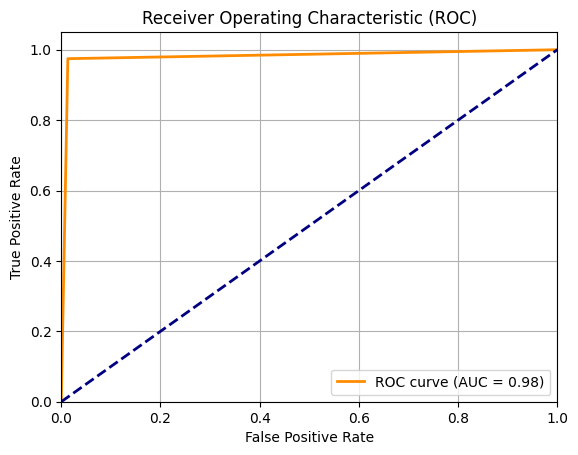

Tree depth 19
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

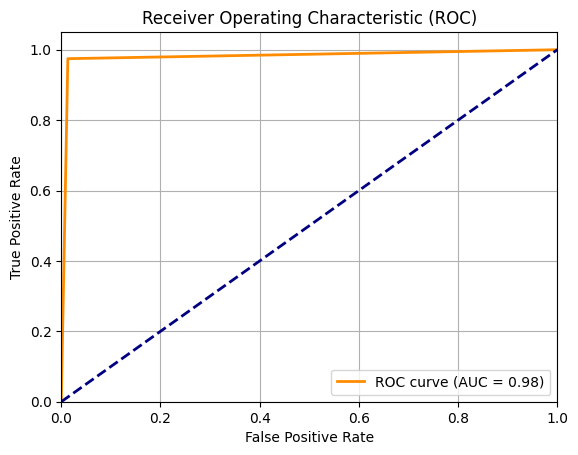

Tree depth 20
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

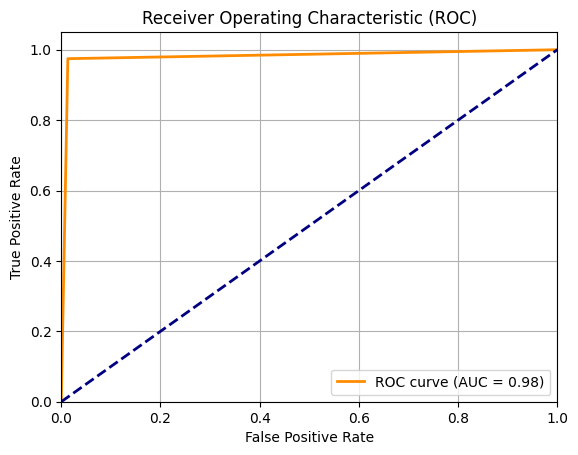

Tree depth 21
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

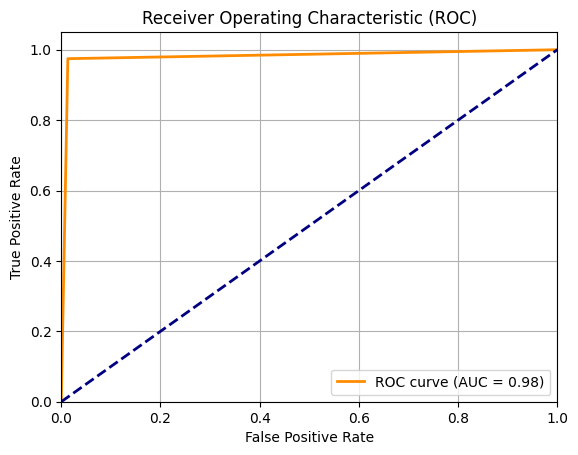

Tree depth 22
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

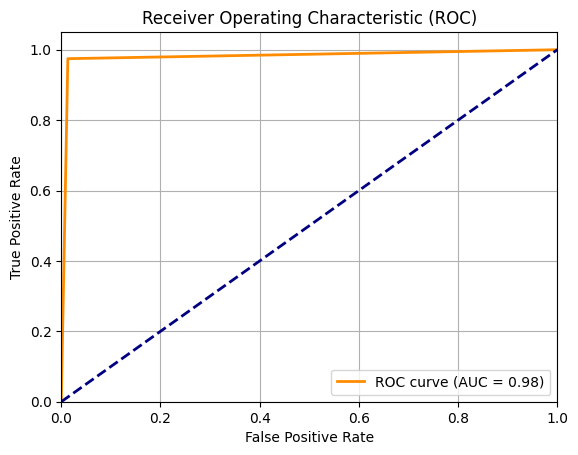

Tree depth 23
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

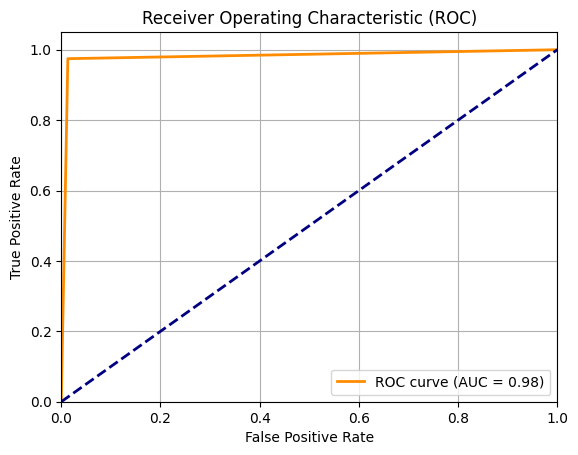

Tree depth 24
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

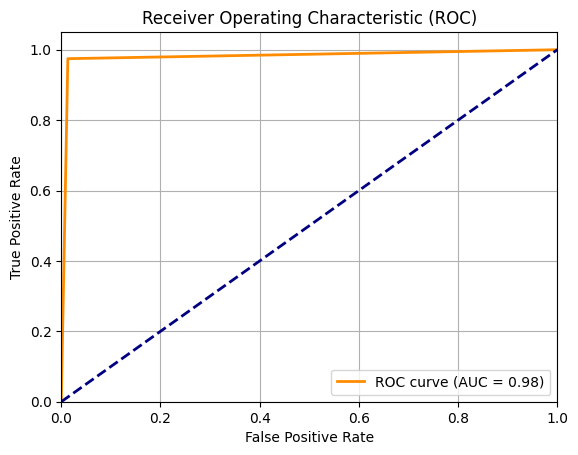

Tree depth 25
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

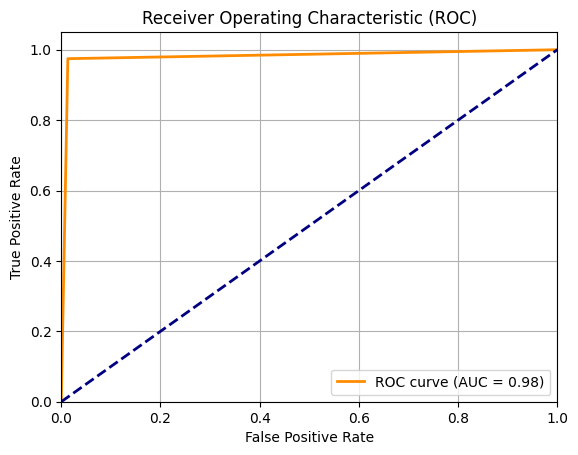

Tree depth 26
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

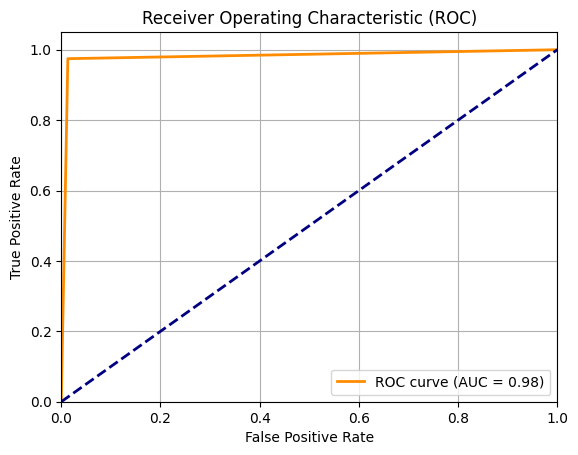

Tree depth 27
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

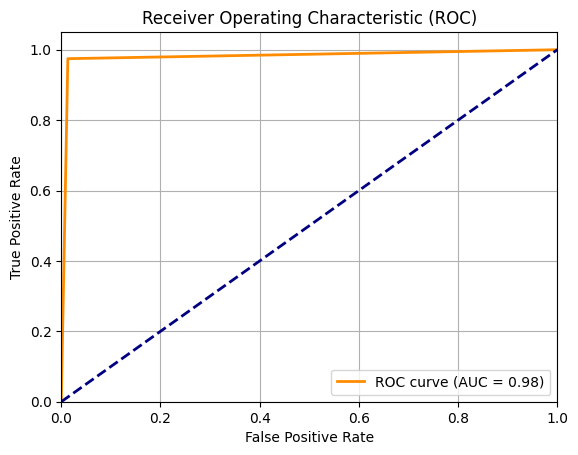

Tree depth 28
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

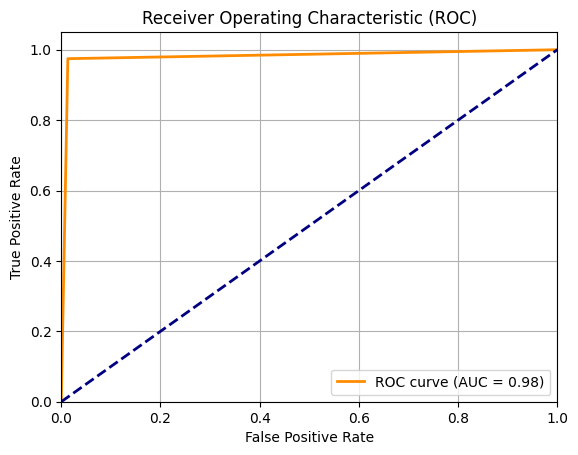

Tree depth 29
backers_count                  0.377946
usd_pledged                    0.280042
goal                           0.245874
launch_to_state_change_days    0.024276
canceled                       0.022333
static_usd_rate                0.018791
disable_communication          0.008082
launch_to_deadline_days        0.003432
launched_at_yr                 0.002157
deadline_day                   0.001763
blurb_len_clean                0.001614
launched_at_month              0.001499
created_at_month               0.001486
created_at_hr                  0.001332
deadline_hr                    0.001252
create_to_launch_days          0.001046
new                            0.000994
created_at_day                 0.000993
launched_at_day                0.000847
name_len_clean                 0.000757
world                          0.000637
launched_at_hr                 0.000614
help                           0.000555
DeadlineWeekend                0.000475
staff_pick                

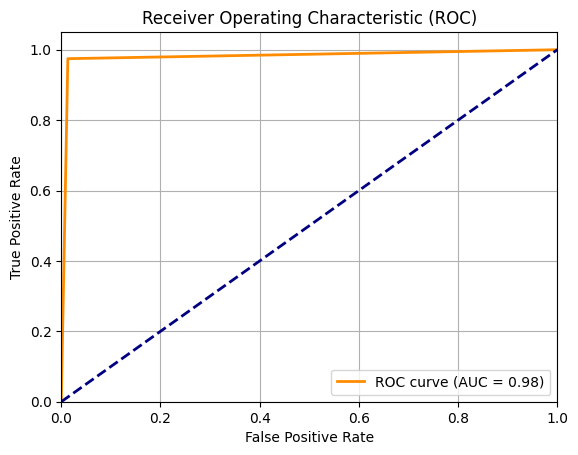

In [ ]:
model_score_stats = []

for i in range(1, 30):
    print(f"Tree depth {i}")

    clf = DecisionTreeClassifier(max_depth=i, random_state=42)
    clf.fit(X_train, y_train)

    cv_scores = cross_val_score(clf, X, y, cv=10)

    #examine the feature importance
    importances = clf.feature_importances_
    feature_ranks = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    filtered_ranks = feature_ranks[feature_ranks > 0]
    print(filtered_ranks)
    #for index, value in zip(feature_ranks.index, feature_ranks.values):
    #    print(index, value)
    #print(feature_ranks)
    #split_feature_index = clf.tree_.feature[0]
    #print("Split on feature:", X.columns[split_feature_index])

    model_score_stats.append({"model": clf, "depth": i, "mean_score": cv_scores.mean(), "score_std":cv_scores.std()})

    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {cv_scores.mean():.4f}")
    print(f"Standard deviation of accuracy: {cv_scores.std():.4f}")

    y_scores = clf.predict_proba(X_test)[:, 1]  # Get probability for the positive class

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
        

In [ ]:
max_score = max(model_score_stats, key=lambda x: x['mean_score'])
min_std = min(model_score_stats, key=lambda x: x['score_std'])

print(f"maximum average score parameters {max_score}")
print(f"minimum score standard deviation parameters {min_std}")

maximum average score parameters {'depth': 12, 'mean_score': np.float64(0.9816785078176962), 'score_std': np.float64(0.006578979087999869)}
minimum score standard deviation parameters {'depth': 19, 'mean_score': np.float64(0.9799337581305165), 'score_std': np.float64(0.006159825160945401)}


### Test Results ###

In cross validation testing, it appears that a tree depth of 12 has the highest average score for the 10 folds. A depth of 19 has the minimum standard deviation among the scores. The standard deviation in both cases is very low.